In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# a)

In [37]:
#Units Constants
G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
c = 299792458    # Speed of light (m/s)
solar_mass = 1.989e30  # Solar mass (kg)
length_unit = 1477
time_unit = 4.927e-6
pressure_limit = 1e-8


pi = np.pi

In [48]:
def polytope(K, rho):
    return K*(rho**2)

# TOV equations:

# def dm_dr(r):
#     return 4*pi*r**2*rho

# def dnu_dr(r):
#     return 2*(m + 4*pi * r**3 * rho) / (r * (r - 2*m))

# def dp_dr(r):
#     return -0.5 * (rho + p) * dv_dr(r)

def tov_equations(r, y):
    m, nu, p = y
    
    
    rho = (p / K)**(1/2) if p > 0 else 0
    
    if p <= 0:  # Stop condition
        return [0, 0, 0]
    
    if r == 0:
        dm_dr = 4 * pi * r**2 * rho
        dnu_dr = 0
        dp_dr = 0
    else:
        dm_dr = 4 * np.pi * r**2 * rho
        dnu_dr =  2*(m + 4*pi * r**3 * p) / (r * (r - 2*m))
        dp_dr =  -0.5 * (rho + p) * nu
    return [dm_dr, dnu_dr, dp_dr]

# Stop condition: Pressure drops to zero
def pressure_zero(r, y):
    return y[2]  # Pressure is the third element in y

pressure_zero.terminal = True


def solve_tov(p_c):
    r_init = 1e-6  # Avoid singularity at the center
    m_init = 0  # Initial mass is zero
    nu_init = 0
    y_init = np.asarray([m_init,nu_init, p_c]).astype(float)

    # Integration using Runge-Kutta 4
    r_span = [r_init, 1e5]  # Adjust the upper bound as needed
    sol = solve_ivp(tov_equations, r_span, y_init, method='RK45', rtol=1e-6, atol=1e-6, events=pressure_zero)

    
    return sol.y[0,-1], sol.t[-1]
    





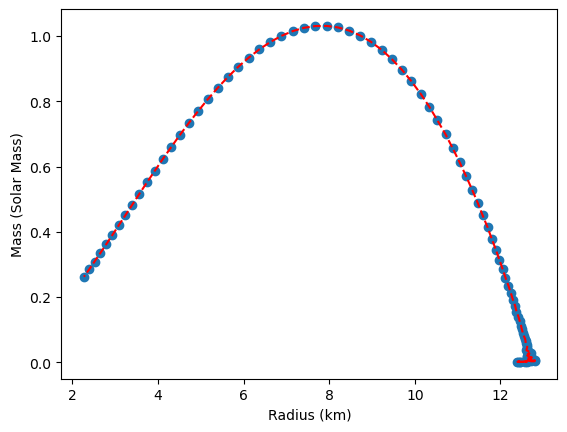

In [39]:
# Equation Parameters
K = 200
N = 100 # Sample size

# Preparing 
rho_vals = np.logspace(-6,-1, N)
central_pressures = polytope(K, rho_vals)  # vary central pressures
masses = []
radii = []

for p_c in central_pressures:
    sol = solve_tov(p_c)
    m, r = sol
    masses.append(m)  # convert to solar masses
    radii.append(r / 1000 )  # convert to kilometers

radii = np.asarray(radii).astype(float)
masses = np.asarray(masses).astype(float)

#Plot the result
plt.figure()
plt.scatter(x=radii*length_unit, y=masses)
plt.plot(radii*length_unit, masses, '--', color='red')
plt.xlabel('Radius (km)')
plt.ylabel('Mass (Solar Mass)')
plt.show()

# b)

In [73]:
def tov_equations_part_b(r, y, K):
    m, nu, p, mp = y
    rho = (p / K)**(1/2) if p > 0 else 0
    
    if p <= 0:  # Stop condition
        return [0, 0, 0, 0]
    
    if r == 0:
        dmp_dr = 0
        dnu_dr = 0
        dp_dr = 0
    else:
        dm_dr = 4 * pi * r**2 * rho
        dnu_dr =  2*(m + 4*pi * r**3 * p) / (r * (r - 2*m))
        dp_dr =  -0.5 * (rho + p) * nu
        
        # additionally return dmp_dr
        dmp_dr = 4*pi * (1 - 2*m/r)**(-1/2) * r**2 * rho
    return [dm_dr, dnu_dr, dp_dr, dmp_dr]

def solve_tov_part_b(p_c,K):
    r_init = 1e-6  # Avoid singularity at the center
    m_init = 0  # Initial mass is zero
    nu_init = 0
    mp_init = 0
    y_init = np.asarray([m_init,nu_init, p_c, mp_init]).astype(float)

    # Integration using Runge-Kutta 4
    r_span = [r_init, 1e5]  # Adjust the upper bound as needed
    sol = solve_ivp(tov_equations_part_b, r_span, y_init, args=(K,), method='RK45', rtol=1e-6, atol=1e-6, events=pressure_zero)

    
    return sol.y[0,-1], sol.t[-1], sol.y[3, -1] # additionally return mp
    

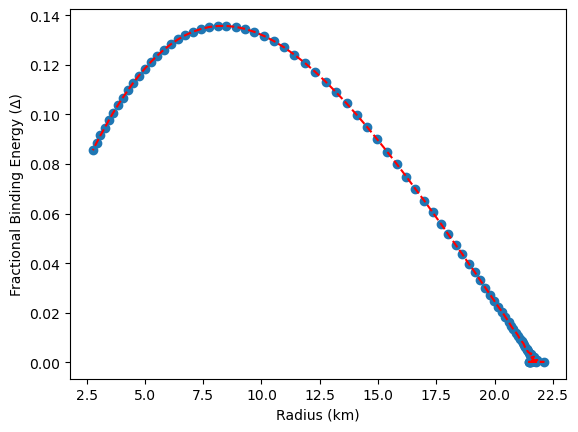

In [53]:
# computing delta values 
delta_vals = []
masses = []
radii = []
for p_c in central_pressures:
    m, r, m_p = solve_tov_part_b(p_c,K)

    if m > 0: # avoid division by zero
        delta = (m_p - m) / m
        delta_vals.append(delta)
        masses.append(m ) # convert to solar masses
        radii.append(r / 1000) # convert to kilometers

radii = np.asarray(radii).astype(float)
delta_vals = np.asarray(delta_vals).astype(float)

# plotting delta vs R

plt.figure()
plt.scatter(x=radii * length_unit, y=delta_vals)
plt.plot(radii * length_unit, delta_vals, '--', color='red')
plt.xlabel('Radius (km)')
plt.ylabel('Fractional Binding Energy (Δ)')
plt.show()



# c)

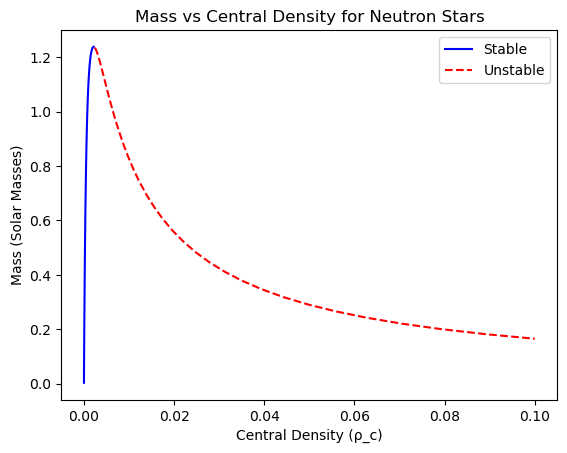

Maximal Neutron Star Mass: 1.24 Solar Masses


In [54]:
masses = []
rho_c_vals = rho_vals

for p_c in central_pressures:
    _, _, mp = solve_tov_part_b(p_c,K)
    masses.append(mp) 

masses = np.asarray(masses)

# Compute dM/dρc
dMp_dRho = np.gradient(masses, rho_c_vals)

# Identify stable and unstable regions
stable_rho_c = rho_c_vals[dMp_dRho > 0]
unstable_rho_c = rho_c_vals[dMp_dRho < 0]
stable_masses = masses[dMp_dRho > 0]
unstable_masses = masses[dMp_dRho < 0]

# Plotting
plt.figure()
plt.plot(stable_rho_c, stable_masses, label='Stable', color='blue')
plt.plot(unstable_rho_c, unstable_masses, label='Unstable', linestyle='dashed', color='red')
plt.xlabel('Central Density (ρ_c)')
plt.ylabel('Mass (Solar Masses)')
plt.title('Mass vs Central Density for Neutron Stars')
plt.legend()
plt.show()

# Report maximal NS mass
max_mass = np.max(masses)
print(f"Maximal Neutron Star Mass: {max_mass:.2f} Solar Masses")

# d)

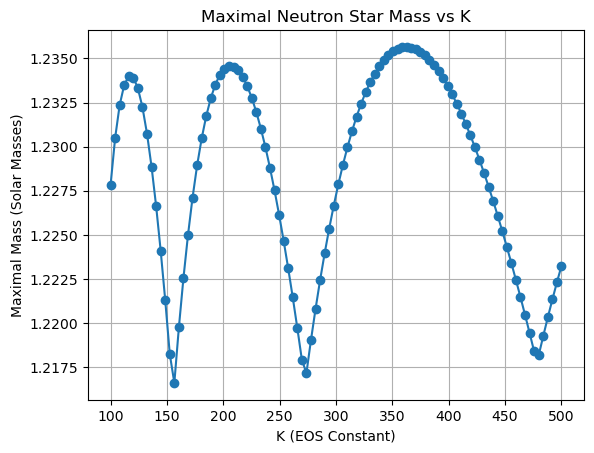

Allowed K values for a maximal mass of 2.14 M⊙
[100.         104.04040404 108.08080808 112.12121212 116.16161616
 120.2020202  124.24242424 128.28282828 132.32323232 136.36363636
 140.4040404  144.44444444 148.48484848 152.52525253 156.56565657
 160.60606061 164.64646465 168.68686869 172.72727273 176.76767677
 180.80808081 184.84848485 188.88888889 192.92929293 196.96969697
 201.01010101 205.05050505 209.09090909 213.13131313 217.17171717
 221.21212121 225.25252525 229.29292929 233.33333333 237.37373737
 241.41414141 245.45454545 249.49494949 253.53535354 257.57575758
 261.61616162 265.65656566 269.6969697  273.73737374 277.77777778
 281.81818182 285.85858586 289.8989899  293.93939394 297.97979798
 302.02020202 306.06060606 310.1010101  314.14141414 318.18181818
 322.22222222 326.26262626 330.3030303  334.34343434 338.38383838
 342.42424242 346.46464646 350.50505051 354.54545455 358.58585859
 362.62626263 366.66666667 370.70707071 374.74747475 378.78787879
 382.82828283 386.86868687 39

In [74]:
K_values = np.linspace(100, 500, 100)  # Range of K values to test
N = 50  # Number of central densities

max_masses = []

for K in K_values:
    masses = []
    central_densities = np.logspace(-6, 6, N)
    for rho_c in central_densities:
        p_c = polytope(K, rho_c) # corresponding central pressure
        _, _, mp = solve_tov_part_b(p_c, K)
        masses.append(mp)
    max_masses.append(np.max(masses))

# Plot M_max(K) vs K
plt.figure()
plt.plot(K_values, max_masses, '-o')
plt.xlabel('K (EOS Constant)')
plt.ylabel('Maximal Mass (Solar Masses)')
plt.title('Maximal Neutron Star Mass vs K')
plt.grid()
plt.show()

# Determine allowed K values for observed maximal mass of 2.14 M⊙
observed_max_mass = 2.14
# Regarding the observation of the most massive neutron star of 2.14M⊙ we can infer that possible K values must result in less mass after solving TOV equations
allowed_K_values = K_values[np.array(max_masses) <= observed_max_mass]

print("Allowed K values for a maximal mass of 2.14 M⊙")
print(allowed_K_values)

## tried with implicit method due to stability of implicit methods but it didn't converge

In [71]:
from scipy.optimize import fsolve

def tov_functions(r, m, p,K, eos):
    rho = eos(p,K)
    fm = 4 * np.pi * r**2 * rho
    fp = -((rho + p) * (m + 4 * np.pi * r**3 * p)) / (r * (r - 2 * m))
    return fm, fp

def implicit_euler_step(r, m, p, dr, eos):
    def equations(x):
        m_next, p_next = x
        fm, fp = tov_functions(r + dr, m_next, p_next, K, eos)
        return [m_next - m - dr * fm, p_next - p - dr * fp]

    m_next, p_next = fsolve(equations, [m, p])
    return m_next, p_next

def solve_tov_implicit_euler(rho_c, K, eos, r_max, dr):
    r = dr  # start just outside r = 0 to avoid singularity
    m = 0
    p = eos(rho_c,K)

    radius, mass, pressure = [], [], []

    while p > 0 and r < r_max:
        radius.append(r)
        mass.append(m)
        pressure.append(p)

        m, p = implicit_euler_step(r, m, p, dr, eos)
        r += dr

    return radius, mass, pressure

# Example usage
def polytropic_eos(p,K):
    Gamma = 2  # Adiabatic index
    return (p / K)**(1 / Gamma)

rho_c = 1e18  # central density in kg/m^3
r_max = 1e6  # maximum radius to integrate to in meters
dr = 100  # step size in meters

#radius, mass, pressure = solve_tov_implicit_euler(rho_c, K, polytropic_eos, r_max, dr)

In [72]:
K_values = np.linspace(100, 500, 10)  # Range of K values to test
N = 10  # Number of central densities

max_masses = []

for K in K_values:
    masses = []
    central_densities = np.logspace(-6, 6, N)
    for rho_c in central_densities:
        p_c = polytope(K, rho_c) # corresponding central pressure
        _, mp, _ = solve_tov_implicit_euler(rho_c, K, polytropic_eos, r_max, dr)
        masses.append(mp)
    max_masses.append(np.max(masses))

# Plot M_max(K) vs K
plt.figure()
plt.plot(K_values, max_masses, '-o')
plt.xlabel('K (EOS Constant)')
plt.ylabel('Maximal Mass (Solar Masses)')
plt.title('Maximal Neutron Star Mass vs K')
plt.grid()
plt.show()

# Determine allowed K values for observed maximal mass of 2.14 M⊙
observed_max_mass = 2.14
# Regarding the observation of the most massive neutron star of 2.14M⊙ we can infer that possible K values must result in less mass after solving TOV equations
allowed_K_values = K_values[np.array(max_masses) <= observed_max_mass]

print("Allowed K values for a maximal mass of 2.14 M⊙")
print(allowed_K_values)

C:\Users\Ege\AppData\Local\Temp\ipykernel_13136\782712875.py:38: RuntimeWarning: invalid value encountered in double_scalars
  return (p / K)**(1 / Gamma)
C:\Users\Ege\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 